In [1]:
from icecube import icetray, dataio, dataclasses, simclasses, phys_services, recclasses
import os, sys
import numpy as np
import matplotlib as mpl
from matplotlib.colors import LogNorm, Normalize
import matplotlib.pyplot as plt
import timeit as time
import math
from datetime import datetime

In [2]:
plt.rcParams.update({'font.size': 20})
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

mpl.rcParams['hist.bins'] = 100
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['patch.linewidth'] = 2.5
mpl.rcParams['grid.alpha'] = 0.2

In [3]:
# Added by JP
# Define the directory of your files
files_dir = '/data/icecube/domeff_analysis/reco_sim_nominal/0000000-0000999'
# List the contents of the entire directory
file_list_aux = os.listdir(files_dir)
# Only keep those that are I3 files
file_list = [x for x in file_list_aux if '.i3.bz2' in x]
print('Total files', len(file_list))

Total files 966


In [4]:
# Now decide how many files to loop over
nfiles = 2 # This could be len(file_list)
frame_arr = []; mctree = []
track_list = []
for i in range(nfiles):
    # This is your code, but I changed the file name creation
    with dataio.I3File(os.path.join(files_dir, file_list[i])) as infile:
        for frame in infile:
            if infile.stream.id != 'P': continue
            frame_arr.append(frame)
            mctree.append(frame['I3MCTree']) 
           

In [5]:
volume_radius = 500. # In meters
volume_top    = 500. # In meters

In [6]:
# Initialize the array

muon_index = np.zeros(len(frame_arr),dtype=int)
counter_single = 0
counter_multi_reject = 0
# This is a useful way to loop over a list in python
for index, frame in enumerate(frame_arr):
    mmc_tracks = frame['MMCTrackList']
    
    if len(mmc_tracks) == 1:
        muon_index[index] = 0
        counter_single += 1
    else:
        # If more than one muon in the event, I need to find out their decay point
        # And whether they entered the detector
        muons_in_volume = 0
        for itrack, one_track in enumerate(mmc_tracks):
            # Check if the closest approach of the muon to the origin is within the detector radius
            if (np.sqrt(one_track.xc**2 + one_track.yc**2) < volume_radius) and (-volume_top<one_track.zc<volume_top):
                # If I land here, this muon could have entered my volume. Let's find out where it decayed
                if one_track.particle.shift_along_track(one_track.particle.length).z < volume_top:
                    # This muon decayed under 500m, so it entered the volume.              
                    muons_in_volume += 1
                    muon_index[index] = itrack
        # After looping, check how many muons in volume I counted. If more than one, this is a bad event!
        if muons_in_volume > 1:
            muon_index[index] = -1
            counter_multi_reject += 1
        

In [7]:
# Let's have a look now
print('Total events (frames)', len(frame_arr))
print('Single muons', counter_single)
print('Real bundles (multiple muons in my volume)', counter_multi_reject)
print('Fake bundles (single muouns in volume)', len(frame_arr)-counter_single-counter_multi_reject)

Total events (frames) 2592
Single muons 1702
Real bundles (multiple muons in my volume) 684
Fake bundles (single muouns in volume) 206


In [8]:
muon_index

array([ 0,  0,  0, ..., -1, -1, -1])

In [253]:
# We dont want ANY of those real bundles. We should look at how to cut them later
# Let's turn back to the single muons and fake bundles now

In [19]:
#print(mctree)
muons_pos = []
muons_length = []
entering_large_cylinder = []
d_injection_cylinder = []
d_inside = []
e_ion = []
daughters = []
# JP: I added a track of the stochastic losses
e_stochastic = []



for i, frame in enumerate(frame_arr):
    # JP: I changed this to run over single muons and fake bundles
    if muon_index[i] < 0:
        # It's a real bundle, don't go there
        continue
        
    mmc_tr = frame['MMCTrackList'][int(muon_index[i])]
    mctree = frame['I3MCTree']
 

    # JP note: 
    # I had all these checks on the ionization + stochastic losses just to show you how the code works
    # You don't need to do this anymore, but it is nice that you understand how it works
    # Everything from here until ...
    muons_pos.append(mmc_tr.particle.pos)
    muons_length.append(mmc_tr.particle.length)
    entering_large_cylinder.append(dataclasses.I3Position(mmc_tr.xi, mmc_tr.yi, mmc_tr.zi))
    d_injection_cylinder.append((mmc_tr.particle.pos - dataclasses.I3Position(mmc_tr.xi, mmc_tr.yi, mmc_tr.zi)).magnitude)
    d_inside.append(mmc_tr.particle.length - (mmc_tr.particle.pos - dataclasses.I3Position(mmc_tr.xi, mmc_tr.yi, mmc_tr.zi)).magnitude)
    e_ion.append((1/4.5)*(mmc_tr.particle.length - (mmc_tr.particle.pos - dataclasses.I3Position(mmc_tr.xi, mmc_tr.yi, mmc_tr.zi)).magnitude))
    # ... here is not necessary anymore.

    # This is necessary. First get all the daughters
    daughters=(mctree.get_daughters(mmc_tr.particle))

    # Then look for the daughters inside the volume. I added the volume definition in a new block of code
    # First loop over the daughters and start the energy loss counter
    e_stochastic.append(0)
    for d in daughters:
        # Check their position, only count if inside the volume
        if (d.pos.z <= volume_top) and (np.sqrt(d.pos.x**2 + d.pos.y**2)< volume_radius):
            # Sum the energy of the daughter to the last entry of the counter (index -1)
            e_stochastic[-1] += d.energy
    
            
muons_pos = np.array(muons_pos)
muons_lenght = np.array(muons_length)
entering_large_cylinder = np.array(entering_large_cylinder)
d_injection_cylinder = np.array(d_injection_cylinder)
e_ion = np.array(e_ion)
daughters = np.array(daughters)
e_stochastic = np.array(e_stochastic)



print('Injection point of the first muon in file 83', muons_pos[0])
print('Length that the first muon in file 83 traveled in total', muons_length[0])
print('Point where it enters the 800m volume', entering_large_cylinder[0])
print('Distance from injection to 800m volume', d_injection_cylinder[0])
print('Ionization losses', e_ion[0])
print('Total stochastics', len(e_stochastic))
print('how many events without shochastic?', len(frame_arr)-len(e_stochastic))

Injection point of the first muon in file 83 [-227.48417893 1017.21534929 1949.99477481]
Length that the first muon in file 83 traveled in total 3125.5943701684264
Point where it enters the 800m volume [-115.17625567  542.97290035  800.        ]
Distance from injection to 800m volume 1249.0023827390578
Ionization losses 417.0204416509708
Total stochastics 1908
how many events without shochastic? 684


Text(0, 0.5, 'Events')

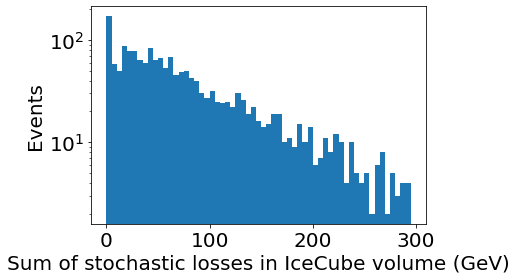

In [22]:
# JP - I'm done! I can make a figure now of the energy losses
plt.hist(e_stochastic, np.arange(0, 300, 5))
plt.yscale('log')
plt.xlabel('Sum of stochastic losses in IceCube volume (GeV)')
plt.ylabel('Events')

In [14]:
# Looks like I have a lot of events without any stochastic losses, that's great

# Now let's see if I find a correlation with muon characteristics

# .How about their zenith angle? 

# .Or the entry point to the detector in z?

# ???or their brightness? 

# .or the maximum number of photons detected in a sensor?

# These are detector properties. I'll show you how to access the PULSES (the accounting unit of light) below

# These are properties that you can get from the track itself and do a scatter plot

In [99]:
# I'll show you with a single frame
frame = frame_arr[1]
# The frame already has these condensed data about light observed in this object
hitstats = frame['HitStatisticsValues'] # I needed to add an import at the top (from icecube import recclasses)
print('This is all the info from the object')
print(hitstats)
print('This is an estimate of the total number of photons seen', hitstats.q_tot_pulses)
print('This is the highest number of photons in a single sensor', hitstats.q_max_doms)



This is all the info from the object
I3HitStatisticsValues(COG: I3Position(-70.8518,-176.917,-199.305), COGZSigma [m]: 315.188, MinPulseTime [ns]: 9851, MaxPulseTime [ns]: 15357, QMaxDoms [PE]: 2.4, QTotPulses [PE]: 37.925, ZMin [m]: -507.28, ZMax [m]: 449.47, ZMean [m]: -183.358, ZSigma [m]: 328.649, ZTravel [m]: -457.864)
This is an estimate of the total number of photons seen 37.92499989271164
This is the highest number of photons in a single sensor 2.399999976158142


In [ ]:
# I have added a record of this to the exercise from above
# I'm copying code just to show you how easy it is. Avoid copying code in a notebook. Better to reuse or make functions.

In [24]:
#print(mctree)

daughters = []
# JP: I added a track of the stochastic losses
e_stochastic = []
# I'll keep track of the maximum charge observed
qmax = []


for i, frame in enumerate(frame_arr):
    # JP: I changed this to run over single muons and fake bundles
    if muon_index[i] < 0:
        # It's a real bundle, don't go there
        continue
        
    mmc_tr = frame['MMCTrackList'][int(muon_index[i])]
    mctree = frame['I3MCTree']
    
    # New
    hitstats = frame['HitStatisticsValues']
    qmax.append(hitstats.q_max_doms)


    daughters=(mctree.get_daughters(mmc_tr.particle))

    # Then look for the daughters inside the volume. I added the volume definition in a new block of code
    # First loop over the daughters and start the energy loss counter
    e_stochastic.append(0)
    for d in daughters:
        # Check their position, only count if inside the volume
        if (d.pos.z <= volume_top) and (np.sqrt(d.pos.x**2 + d.pos.y**2)< volume_radius):
            # Sum the energy of the daughter to the last entry of the counter (index -1)
            e_stochastic[-1] += d.energy
        
            

e_stochastic = np.array(e_stochastic)
qmax = np.array(qmax)
print(e_stochastic )

[ 79.04368453 325.36527686 108.12042881 ...   0.           7.35405583
  87.08696783]


In [25]:
e_stochastic.max()

7500.245304936871

Text(0, 0.5, 'Max Q observed')

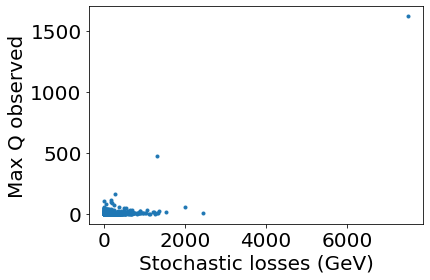

In [26]:
# Now do a scatter plot
plt.plot(e_stochastic, qmax, '.')
plt.xlabel('Stochastic losses (GeV)')
plt.ylabel('Max Q observed')
# That outlier makes things hard, let's zoom

(0.0, 100.0)

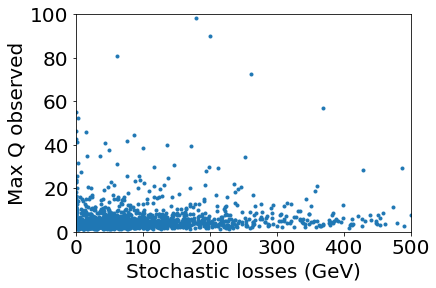

In [36]:
plt.plot(e_stochastic, qmax, '.')
plt.xlabel('Stochastic losses (GeV)')
plt.ylabel('Max Q observed')
plt.xlim(0,500)
plt.ylim(0,100)
# One can try with a histogram in 2D, but I don't really see a correlation. Too bad.
# Try doing the same with the other parameters

(1908,)


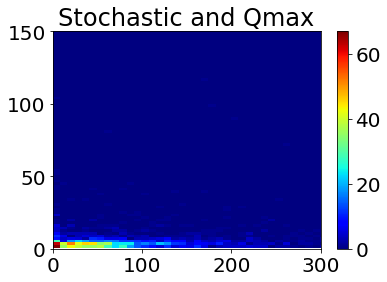

In [51]:
a = e_stochastic
b = qmax
print(np.shape(a))
plt.hist2d(a, b , bins=(900, 900), cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(0,300)
plt.ylim(0,150)
plt.title('Stochastic and Qmax')
plt.show()

(1908,)
(1908, 3)
[-272.62986256 -199.30541897 -144.24221432 ... -239.61918144 -378.84564616
 -218.21188704]
(1908,)


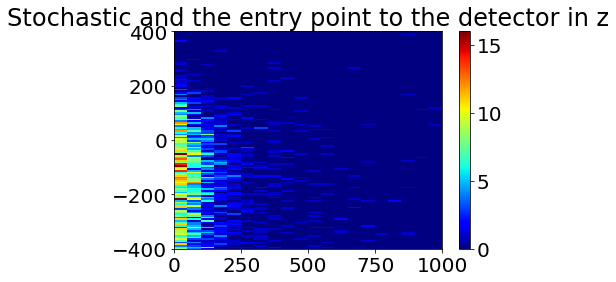

[-272.62986256 -199.30541897 -144.24221432 ... -239.61918144 -378.84564616
 -218.21188704]


In [98]:
# Or the entry point to the detector in z? 
#print(len(frame_arr))

daughters = []
e_stochastic = []
muons_pos = []


for i, frame in enumerate(frame_arr):
    if muon_index[i] < 0:
        continue
        
    mmc_tr = frame['MMCTrackList'][int(muon_index[i])]
    mctree = frame['I3MCTree']
    
    # New
    hitstats = frame['HitStatisticsValues']
    muons_pos.append(dataclasses.I3Position(hitstats.cog))


    daughters=(mctree.get_daughters(mmc_tr.particle))

    # Then look for the daughters inside the volume. I added the volume definition in a new block of code
    # First loop over the daughters and start the energy loss counter
    e_stochastic.append(0)
    for d in daughters:
        # Check their position, only count if inside the volume
        if (d.pos.z <= 500.0) and (np.sqrt(d.pos.x**2 + d.pos.y**2)< volume_radius):
            # Sum the energy of the daughter to the last entry of the counter (index -1)
            e_stochastic[-1] += d.energy
        
            

e_stochastic = np.array(e_stochastic)
muons_pos = np.array(muons_pos)
print(np.shape(e_stochastic) )
print(np.shape(muons_pos))
print(muons_pos[:,2])

mu = muons_pos[:,2]
#print(np.shape(mu))
#print(mu)

a = e_stochastic
b = mu
print(np.shape(a))
plt.hist2d(a, b , bins=(150, 150), cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(0,1000)
plt.ylim(-400,400)
plt.title('Stochastic and the entry point to the detector in z')
plt.show()

print(mu)

(-500.0, 500.0)

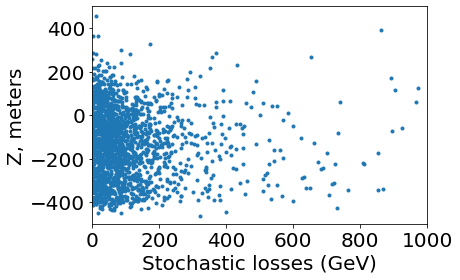

In [94]:
plt.plot(e_stochastic, mu, '.')
plt.xlabel('Stochastic losses (GeV)')
plt.ylabel('Z, meters')
plt.xlim(0,1000)
plt.ylim(-500,500)

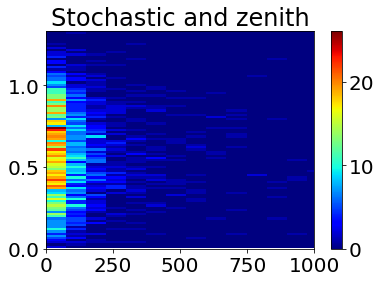

1.3306182968203988


In [84]:
# How about their zenith angle? 
daughters = []
e_stochastic = []
zenith = []


for i, frame in enumerate(frame_arr):
    if muon_index[i] < 0:
        continue
        
    mmc_tr = frame['MMCTrackList'][int(muon_index[i])]
    mctree = frame['I3MCTree']
    
    zenith.append(mmc_tr.particle.dir.zenith)


    daughters=(mctree.get_daughters(mmc_tr.particle))

    # Then look for the daughters inside the volume. I added the volume definition in a new block of code
    # First loop over the daughters and start the energy loss counter
    e_stochastic.append(0)
    for d in daughters:
        # Check their position, only count if inside the volume
        if (d.pos.z <= volume_top) and (np.sqrt(d.pos.x**2 + d.pos.y**2)< volume_radius):
            # Sum the energy of the daughter to the last entry of the counter (index -1)
            e_stochastic[-1] += d.energy
        
            

e_stochastic = np.array(e_stochastic)
zenith = np.array(zenith)

plt.hist2d(e_stochastic, zenith , bins=(100, 100), cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(0,1000)
plt.ylim(0,1.33)
plt.title('Stochastic and zenith')
plt.show()
print(max(zenith))

(0.0, 1.33)

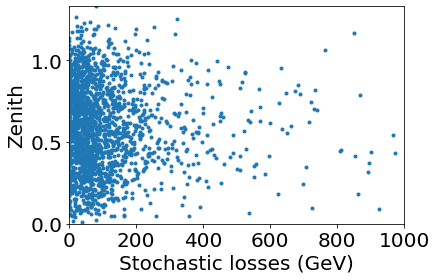

In [82]:
plt.plot(e_stochastic, zenith, '.')
plt.xlabel('Stochastic losses (GeV)')
plt.ylabel('Zenith')
plt.xlim(0,1000)
plt.ylim(0,1.33)

In [100]:

# I'll show you with a single frame
frame = frame_arr[1]
# The frame already has these condensed data about light observed in this object
hitstats = frame['HitStatisticsValues'] # I needed to add an import at the top (from icecube import recclasses)
print('This is all the info from the object')
print(hitstats)
print('This is an estimate of the total number of photons seen', hitstats.q_tot_pulses)
print('This is the highest number of photons in a single sensor', hitstats.q_max_doms)


This is all the info from the object
I3HitStatisticsValues(COG: I3Position(-70.8518,-176.917,-199.305), COGZSigma [m]: 315.188, MinPulseTime [ns]: 9851, MaxPulseTime [ns]: 15357, QMaxDoms [PE]: 2.4, QTotPulses [PE]: 37.925, ZMin [m]: -507.28, ZMax [m]: 449.47, ZMean [m]: -183.358, ZSigma [m]: 328.649, ZTravel [m]: -457.864)
This is an estimate of the total number of photons seen 37.92499989271164
This is the highest number of photons in a single sensor 2.399999976158142


[ 79.04368453 325.36527686 108.12042881 ...   0.           7.35405583
  87.08696783]


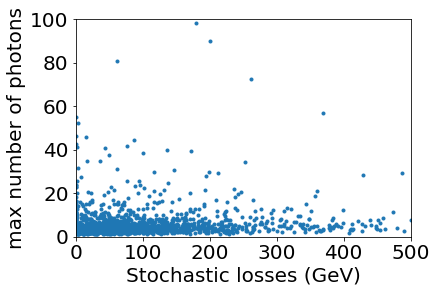

(1908,)


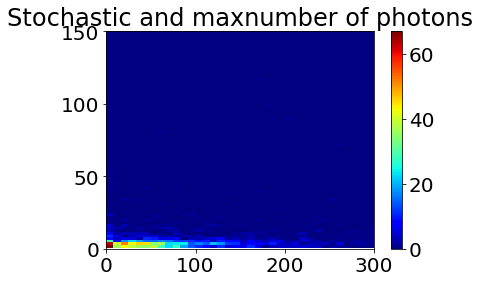

In [151]:
#the highest number of photons in a single sensor
daughters = []
e_stochastic = []
qmax = []


for i, frame in enumerate(frame_arr):
    # JP: I changed this to run over single muons and fake bundles
    if muon_index[i] < 0:
        # It's a real bundle, don't go there
        continue
        
    mmc_tr = frame['MMCTrackList'][int(muon_index[i])]
    mctree = frame['I3MCTree']
    
    # New
    hitstats = frame['HitStatisticsValues']
    qmax.append(hitstats.q_max_doms)


    daughters=(mctree.get_daughters(mmc_tr.particle))

    # Then look for the daughters inside the volume. I added the volume definition in a new block of code
    # First loop over the daughters and start the energy loss counter
    e_stochastic.append(0)
    for d in daughters:
        # Check their position, only count if inside the volume
        if (d.pos.z <= volume_top) and (np.sqrt(d.pos.x**2 + d.pos.y**2)< volume_radius):
            # Sum the energy of the daughter to the last entry of the counter (index -1)
            e_stochastic[-1] += d.energy
        
            

e_stochastic = np.array(e_stochastic)
qmax = np.array(qmax)
print(e_stochastic )

plt.plot(e_stochastic, qmax, '.')
plt.xlabel('Stochastic losses (GeV)')
plt.ylabel('max number of photons')
plt.xlim(0,500)
plt.ylim(0,100)
plt.show()

a = e_stochastic
b = qmax
print(np.shape(a))
plt.hist2d(a, b , bins=(900, 900), cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(0,300)
plt.ylim(0,150)
plt.title('Stochastic and maxnumber of photons')
plt.show()

0.05741948325626178


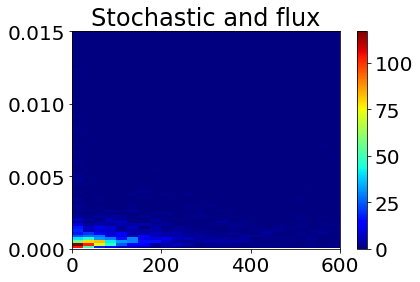

(0.0, 0.015)

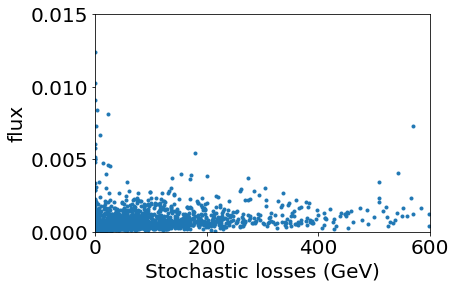

In [144]:
#brightness t use q_tot_pulses
# flux = total number of photons / unit time
# brightness = flux / (unit area * solid angle) ? https://www.cv.nrao.edu/course/astr534/Brightness.html
#http://videoscan.ru/page/714

daughters = []
e_stochastic = []
N_ph = []
time = []
flux = []


for i, frame in enumerate(frame_arr):
    # JP: I changed this to run over single muons and fake bundles
    if muon_index[i] < 0:
        # It's a real bundle, don't go there
        continue
        
    mmc_tr = frame['MMCTrackList'][int(muon_index[i])]
    mctree = frame['I3MCTree']
    
    hitstats = frame['HitStatisticsValues']
    N_ph.append(hitstats.q_tot_pulses)
    time.append((hitstats.max_pulse_time - hitstats.min_pulse_time )* 10**(-9)) #ns to s
    # if unit time is 1 sec, we need to multiply our flux by time
    flux.append(hitstats.max_pulse_time * hitstats.q_tot_pulses* 10**(-9))
    
    #can I consider that sensor is a unit area?
    # if yes then solid angle = 1/ distance 
    #which distance?
    

    daughters=(mctree.get_daughters(mmc_tr.particle))

    e_stochastic.append(0)
    for d in daughters:
        # Check their position, only count if inside the volume
        if (d.pos.z <= volume_top) and (np.sqrt(d.pos.x**2 + d.pos.y**2)< volume_radius):
            # Sum the energy of the daughter to the last entry of the counter (index -1)
            e_stochastic[-1] += d.energy
        
            

e_stochastic = np.array(e_stochastic)
N_ph = np.array(N_ph)
time = np.array(time)
flux = np.array(flux)
print(max(flux))
        


plt.hist2d(e_stochastic, flux , bins=(300, 300), cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(0,600)
plt.ylim(0,0.015)
plt.title('Stochastic and flux')
plt.show()


plt.plot(e_stochastic, flux, '.')
plt.xlabel('Stochastic losses (GeV)')
plt.ylabel('flux')
plt.xlim(0,600)
plt.ylim(0,0.015)

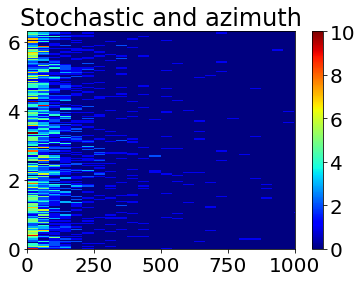

6.282439124892058


(0.0, 6.3)

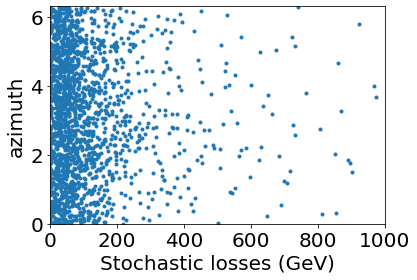

In [170]:
#azimuth
daughters = []
e_stochastic = []
az = []


for i, frame in enumerate(frame_arr):
    if muon_index[i] < 0:
        continue
        
    mmc_tr = frame['MMCTrackList'][int(muon_index[i])]
    mctree = frame['I3MCTree']
    
    az.append(mmc_tr.particle.dir.azimuth)


    daughters=(mctree.get_daughters(mmc_tr.particle))

    # Then look for the daughters inside the volume. I added the volume definition in a new block of code
    # First loop over the daughters and start the energy loss counter
    e_stochastic.append(0)
    for d in daughters:
        # Check their position, only count if inside the volume
        if (d.pos.z <= volume_top) and (np.sqrt(d.pos.x**2 + d.pos.y**2)< volume_radius):
            # Sum the energy of the daughter to the last entry of the counter (index -1)
            e_stochastic[-1] += d.energy
        
            

e_stochastic = np.array(e_stochastic)
az = np.array(az)

plt.hist2d(e_stochastic, az , bins=(180, 180), cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(0,1000)
plt.ylim(0,6.3)
plt.title('Stochastic and azimuth')
plt.show()
print(max(az))

plt.plot(e_stochastic, az, '.')
plt.xlabel('Stochastic losses (GeV)')
plt.ylabel('azimuth')
plt.xlim(0,1000)
plt.ylim(0,6.3)